In [6]:
from google.colab import drive
# drive.mount('/content/gdrive')  # general connection
drive.mount('/content/drive')  # my pickled file path


Mounted at /content/drive


In [0]:
import numpy as np # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import xgboost as xgb
#import r
import time
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score



```
# Connect to Kaggle to download files direction
```



In [0]:
#!pip install kaggle
#from google.colab import files
#files.upload()

#
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

#!kaggle datasets download -d yelp-dataset/yelp-dataset

#! unzip yelp-dataset.zip


```
# Load in pickled business dataframe
```

In [0]:
import os     
print(os.getcwd())

/content


In [17]:
# load pickled file back 

#import pickle
#drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Yelp/"
infile = open(DATA_PATH+'business','rb')
business = pickle.load(infile)
#filename = 'business'
#infile = open(filename,'rb')
#business= pickle.load(infile)
infile.close()

FileNotFoundError: ignored

In [9]:
print(business.shape)
business.head(2) # should be (192127, 9) that contains all cities and both cat =1food =0 non food. 

(192127, 9)


,business_id,name,city,state,stars,review_count,is_open,categories,cat
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,AZ,3.0,5,0,"golf, active life",0
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,1,"specialty food, restaurants, dim sum, imported...",1


In [6]:
#business_id for city == Toronto
#business categories is food

#select city
city="Scottsdale"
print("city is %s" % city)

# select food only
business=business[business['cat']==1]

business=business[business['city']==city]  # change City of analysis: Tempe: all bus = 4536; Toronto all bus = 18876; Scottsdale = 2004 food, 8824 all bus, Lag Vegas = 8286

bus_id=business['business_id'] # for selected city and on food only OR both food non-food
len(bus_id)

city is Scottsdale


2004

# Either prepare or load in pickled df_review_str for sentiment run

### Option 1: Prepare df_review_str from the beginning to include both food and non-food places

In [7]:
#from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#import r
#import time
#start_time = time.time()
#yp_review = pd.read_json("/content/drive/My Drive/Yelp/review.json", lines=True)
#print("yp_review --- %s seconds ---" % (time.time() - start_time))


In [8]:
# prepare df_review_str by loading in yp_review and work from there
# load pickled file back 
#import pickle
#drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Yelp/"
infile = open(DATA_PATH+'yp_review','rb')
yp_review = pickle.load(infile)
infile.close()
print(yp_review.shape)  #(6685900, 9)
yp_review.head(2)   

(6685900, 9)


,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg


In [10]:
# pick out reviews only from selected city on food business
review_df=yp_review[['review_id','business_id','text']]
review_df = review_df.loc[review_df['business_id'].isin(bus_id)] # get review only for selected city
print('unique business_id in dataframe review_df',review_df.business_id.unique().shape) # Tempe (4536,) all business; Toronto  (18876,) all business; Scottsdale (8824,) all bus & (2004,)business for good


unique business_id in dataframe review_df (2004,)


In [11]:
review_df.tail() # Note index not sorted well

,review_id,business_id,text
6685847,wo4A7clfgo3VTjGTrx76lw,4U44KlOxvGG96pxtYYLR5A,This is a hidden gem in old town Scottsdale. ...
6685876,WNMtxgrJ_x9QuIuO_eZIwA,2r6UD7ExSMrK0LGeglquDA,I think this is a place for people who don't u...
6685881,3hynJO9nhrkamssoZxg__Q,AVCD-zzzeaNvC-znOZEhsg,"This place was so convenient, fast, and not at..."
6685887,fnPw5DKCCOZ8a6fWTspZCg,X6XTiVnFH8_YNb5EvSZHsw,Cuteology Cakes created a cake for my Father o...
6685896,jPCXuSBbI_cPocgoNBhdkg,yA6dKNm_zl1ucZCnwW8ZCg,I think this owner and the owner of Amy's Baki...


In [12]:
#make index consistent
review_df = review_df.reset_index(drop=False)
review_df.tail()

,index,review_id,business_id,text
246290,6685847,wo4A7clfgo3VTjGTrx76lw,4U44KlOxvGG96pxtYYLR5A,This is a hidden gem in old town Scottsdale. ...
246291,6685876,WNMtxgrJ_x9QuIuO_eZIwA,2r6UD7ExSMrK0LGeglquDA,I think this is a place for people who don't u...
246292,6685881,3hynJO9nhrkamssoZxg__Q,AVCD-zzzeaNvC-znOZEhsg,"This place was so convenient, fast, and not at..."
246293,6685887,fnPw5DKCCOZ8a6fWTspZCg,X6XTiVnFH8_YNb5EvSZHsw,Cuteology Cakes created a cake for my Father o...
246294,6685896,jPCXuSBbI_cPocgoNBhdkg,yA6dKNm_zl1ucZCnwW8ZCg,I think this owner and the owner of Amy's Baki...


In [13]:
#analysis on the entire review rather than all the words.

df_review_str=review_df['text'].astype(str)
print(df_review_str.shape)# Tempe (202,001,) str for all business; Toronto (525,320,) str for all businesses;Scottsdale (387499,) str for all business & (246295,) for food in Scottsdale

(246295,)


### Option 2: load in the review_df that's cleaned already to only contain food places

In [0]:
###### load in yp_review that are only food
#DATA_PATH = "/content/drive/My Drive/Yelp/"
#infile = open(DATA_PATH+'review_df','rb')
#review_df= pickle.load(infile)
#infile.close()

#print(review_df.shape)  # (246295, 3) for Scottsdale??



# load in text list for sentiment analysis for selected city food places
#DATA_PATH = "/content/drive/My Drive/Yelp/"
#infile = open(DATA_PATH+'df_review_str_Scottsdale','rb')
#df_review_str= pickle.load(infile)
#infile.close()

#print(df_review_str.shape)


(246295, 3)


### Start Sebtiment Analysis

In [8]:
pip install stop_words

In [9]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
from textblob import TextBlob

bloblist_desc = list()

start_time = time.time() 
# Tempe food (128,889,) ran for runtime: --- 4302.755198478699 seconds --- 1.1hr;  Tempe all business: (202001,) runtime: --- 11764.28364610672 seconds --- 3.3hr
# Toronto food (422,050) ran for runtime: --- 36157.76451063156 seconds --- 10 hr; #runtime: --- 37812.02654504776 seconds ---

#for row in df_review_str[0:430,985]:
for row in df_review_str:
    
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['Review','sentiment','polarity'])

print("runtime: --- %s seconds ---" % (time.time() - start_time))

### pickle the result
import pickle
DATA_PATH = "/content/drive/My Drive/Yelp/"
outfile = open(DATA_PATH+'df_polarity_desc_food_%s' %city,'wb')   ################ Make sure file name makes sense 
pickle.dump(df_polarity_desc,outfile)
outfile.close()

print("runtime after pickel %s seconds" % (time.time()-start_time))


######################
# distribution of sentiment score
ax=sns.distplot(df_polarity_desc['sentiment'],label="sentiment")
#ax=sns.boxplot(y=df_polarity_desc['sentiment'], color='red',orient='v', notch=True)
   
ax=sns.distplot(df_polarity_desc['polarity'],label="polarity")
#ax=sns.boxplot(y=df_polarity_desc['polarity'], color='red',orient='v', notch=True)

#ax.legend(['sentiment', 'polarity'])
ax.legend()
plt.xlabel('score', fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.subplot(1,2,1)
ax=sns.boxplot(y=df_polarity_desc['sentiment'], color='red',orient='v', notch=True)
plt.title("boxplot of sentiment")
plt.subplot(1,2,2)
ax=sns.boxplot(y=df_polarity_desc['polarity'], color='royalblue',orient='v', notch=True)
plt.title("boxplot of polarity")
############################

# define postive, negative and neutral review                                   ### question: should I change positive to >0.2, neutral to in range of -0.2 to 0.2?
def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] > 0.2:
        val = 1 #"Positive Review"
    elif df_polarity_desc['sentiment'] < 0:
        val = -1 # "Negative Review"
    else:
        val = 0  #"Neutral Review"
    return val
  
  
# create label for sentiment
df_polarity_desc['Sentiment_Type'] = df_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_polarity_desc)
# comment: mostly postive reviews we can look at the most freq used words in postiive reviews

###############################################################

print(df_polarity_desc.head(2))

# merge dataframe
df=pd.DataFrame()
df['review_id']= review_df.iloc[:,1]
df['business_id']= review_df.iloc[:,2]

df['sentiment']=df_polarity_desc.iloc[:,1]
df['polarity']=df_polarity_desc.iloc[:,2]

#df['polarity']=df_polarity_desc.polarity
df['sentiment_type']=df_polarity_desc.Sentiment_Type
print(df.isnull().sum())




# pickle this City sentiment score file
import pickle
DATA_PATH = "/content/drive/My Drive/Yelp/"
outfile = open(DATA_PATH+'Sentiment_Food_%s' %city,'wb')        ################ Make sure file name makes sense
pickle.dump(df,outfile)
outfile.close()
print('finish pick sentiment for %s' %city)


###################################################################
######
start_time = time.time()
d = {'sentiment': ['mean'],'polarity':['mean'],'sentiment_type':['sum']}
Sentiment_by_Bus= df.groupby(['business_id']).agg(d)

# flatten MultiIndex columns
Sentiment_by_Bus.columns = ['_'.join(col) for col in Sentiment_by_Bus.columns.values]
Sentiment_by_Bus = Sentiment_by_Bus.reset_index(drop=False)
print("runtime aggregate sentiment mean, sum count by positive neg neutral reviews: --- %s seconds ---" % (time.time() - start_time))
######



# pickle this City sentiment score file aggregated by business_id
import pickle
DATA_PATH = "/content/drive/My Drive/Yelp/"
outfile = open(DATA_PATH+'Sentiment_Food_by_Bus_%s'%city,'wb')            ################ Make sure file name makes sense
pickle.dump(Sentiment_by_Bus,outfile)
outfile.close()
print('finish pick sentiment for %s'%city)




NameError: ignored

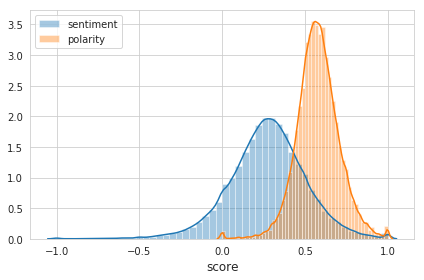

Text(0.5, 1.0, 'boxplot of polarity')

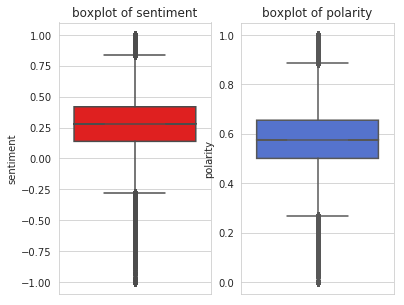

                                              Review  ...  Sentiment_Type
0  This place has gone down hill.  Clearly they h...  ...              -1
1  Love this place downtown but the Scottsdale lo...  ...               0

[2 rows x 4 columns]
review_id         0
business_id       0
sentiment         0
polarity          0
sentiment_type    0
dtype: int64
finish pick sentiment for Scottsdale
runtime aggregate sentiment mean, sum count by positive neg neutral reviews: --- 0.10225296020507812 seconds ---
finish pick sentiment for Scottsdale


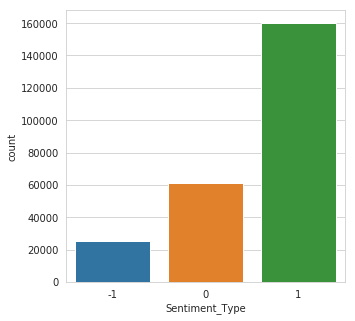

## Sentiment for Tips in Scottsdale

In [12]:
DATA_PATH = "/content/drive/My Drive/Yelp/"
infile = open(DATA_PATH+'df_tip_str','rb')
df_tip_str = pickle.load(infile)
infile.close()
print(df_tip_str .shape)   #(47734,) for scottsdale food tips
df_tip_str.head(2) 

(47734,)


0    Good mix of cuisine
1        Last time... =(
Name: text, dtype: object

runtime: --- 311.5250554084778 seconds ---


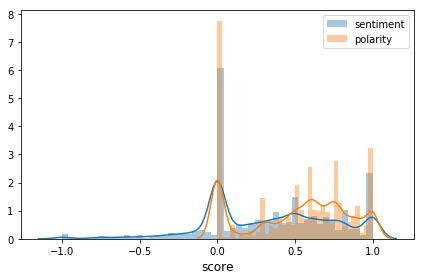

                Review  sentiment  polarity  Sentiment_Type
0  Good mix of cuisine      0.700  0.600000               1
1      Last time... =(     -0.375  0.533333              -1
runtime after pickel 313.0420184135437 seconds


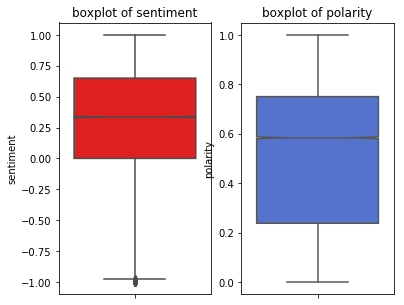

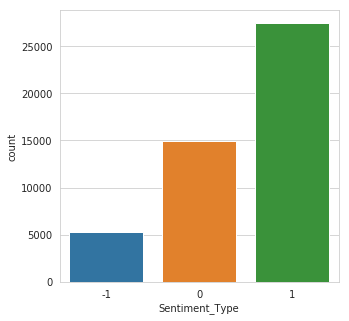

In [13]:
# sentiment analysis on tip for scottsdale food
from textblob import TextBlob

bloblist_desc = list()

start_time = time.time() 

for row in df_tip_str:
    
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['Review','sentiment','polarity'])

print("runtime: --- %s seconds ---" % (time.time() - start_time))


######################
# distribution of sentiment score
ax=sns.distplot(df_polarity_desc['sentiment'],label="sentiment")
#ax=sns.boxplot(y=df_polarity_desc['sentiment'], color='red',orient='v', notch=True)
   
ax=sns.distplot(df_polarity_desc['polarity'],label="polarity")
#ax=sns.boxplot(y=df_polarity_desc['polarity'], color='red',orient='v', notch=True)

#ax.legend(['sentiment', 'polarity'])
ax.legend()
plt.xlabel('score', fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.subplot(1,2,1)
ax=sns.boxplot(y=df_polarity_desc['sentiment'], color='red',orient='v', notch=True)
plt.title("boxplot of sentiment")
plt.subplot(1,2,2)
ax=sns.boxplot(y=df_polarity_desc['polarity'], color='royalblue',orient='v', notch=True)
plt.title("boxplot of polarity")
############################

# define postive, negative and neutral review                                   ### question: should I change positive to >0.2, neutral to in range of -0.2 to 0.2?
def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] > 0.2:
        val = 1 #"Positive Review"
    elif df_polarity_desc['sentiment'] < 0:
        val = -1 # "Negative Review"
    else:
        val = 0  #"Neutral Review"
    return val
  
  
# create label for sentiment
df_polarity_desc['Sentiment_Type'] = df_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_polarity_desc)
# comment: mostly postive reviews we can look at the most freq used words in postiive reviews

###############################################################

print(df_polarity_desc.head(2))

### pickle the sentiment score result ###
import pickle
DATA_PATH = "/content/drive/My Drive/Yelp/"
outfile = open(DATA_PATH+'df_polarity_desc_tip','wb')   ################ Make sure file name makes sense 
pickle.dump(df_polarity_desc,outfile)
outfile.close()

print("runtime after pickel %s seconds" % (time.time()-start_time))




In [0]:
# merge dataframe to tip
df=pd.DataFrame()
df['review_id']= review_df.review_id#iloc[:,1]
df['business_id']= review_df.business_id#iloc[:,2]

df['sentiment']=df_polarity_desc.iloc[:,1]
df['polarity']=df_polarity_desc.iloc[:,2]

#df['polarity']=df_polarity_desc.polarity
df['sentiment_type']=df_polarity_desc.Sentiment_Type
print(df.isnull().sum())

In [0]:


###################################################################
######
start_time = time.time()
d = {'sentiment': ['mean'],'polarity':['mean'],'sentiment_type':['sum']}
Sentiment_by_Bus= df.groupby(['business_id']).agg(d)

# flatten MultiIndex columns
Sentiment_by_Bus.columns = ['_'.join(col) for col in Sentiment_by_Bus.columns.values]
Sentiment_by_Bus = Sentiment_by_Bus.reset_index(drop=False)
print("runtime aggregate sentiment mean, sum count by positive neg neutral reviews: --- %s seconds ---" % (time.time() - start_time))
######



# pickle this City sentiment score file aggregated by business_id
import pickle
DATA_PATH = "/content/drive/My Drive/Yelp/"
outfile = open(DATA_PATH+'Sentiment_Food_by_Bus_%s'%city,'wb')            ################ Make sure file name makes sense
pickle.dump(Sentiment_by_Bus,outfile)
outfile.close()
print('finish pick sentiment for %s'%city)

## Load in pickled files Sentiment on Text to check quality

In [0]:
# load in pickled sentiment, before aggregation by business_id, that are only food
DATA_PATH = "/content/drive/My Drive/Yelp/"
#infile = open(DATA_PATH+'Sentiment_Toronto_Food','rb')
infile = open(DATA_PATH+'Sentiment_Scottsdale_Food','rb')
sentiment_Scottsdale= pickle.load(infile)
infile.close()
#print(sentiment_Toronto.shape)
#sentiment_Toronto.head

print(sentiment_Scottsdale.shape)
sentiment_Scottsdale.head()

(246295, 5)


,review_id,business_id,sentiment,polarity,sentiment_type
0,8e9HxxLjjqc9ez5ezzN7iQ,zvO-PJCpNk4fgAVUnExYAA,-0.048611,0.350278,-1
1,CelUWzp-GnJIiiV1mDUb-g,CDpoJiqgM04wqQTZ6QkTqQ,0.166667,0.333333,1
2,h2lt2Lu8a9jUtYEbB2krhA,oSDyex506Y8H7YegcRb_9g,0.027083,0.566667,1
3,XRCS5zr29DOxlCXKKKwwAw,ZLuWpmvO41w2bSwufgfUlQ,0.583750,0.648333,1
4,lDJIaF4eYRF4F7g6Zb9euw,r5PLDU-4mSbde5XekTXSCA,0.194231,0.472222,1


In [0]:
# load in pickled sentiment, before aggregation by business_id, that are only food
DATA_PATH = "/content/drive/My Drive/Yelp/"
infile = open(DATA_PATH+'Sentiment_Food_by_Bus','rb')
sentiment_by_bus= pickle.load(infile)
infile.close()
print(sentiment_by_bus.shape)
sentiment_by_bus.tail() # compare to origial dataframe Sentiment_Food_by_Bus, look ok

(2004, 4)


,business_id,sentiment_mean,polarity_mean,sentiment_type_sum
1999,zu7DiVAX0wO4f8rGPU8URg,0.188530,0.564384,14
2000,zuVvDYJkKAbXQTTBauAqJQ,0.212569,0.571003,211
2001,zvO-PJCpNk4fgAVUnExYAA,0.122773,0.546139,13
2002,zxWWB54SvtRMa0XcKAhe5g,0.296272,0.568888,14
2003,zyPGYeXF4XKCqNN1pjFWhg,0.359563,0.579705,160


In [0]:
Sentiment_Food_by_Bus.tail() # 

,business_id,sentiment_mean,polarity_mean,sentiment_type_sum
1999,zu7DiVAX0wO4f8rGPU8URg,0.188530,0.564384,14
2000,zuVvDYJkKAbXQTTBauAqJQ,0.212569,0.571003,211
2001,zvO-PJCpNk4fgAVUnExYAA,0.122773,0.546139,13
2002,zxWWB54SvtRMa0XcKAhe5g,0.296272,0.568888,14
2003,zyPGYeXF4XKCqNN1pjFWhg,0.359563,0.579705,160


In [0]:
# load in df_polarity_desc that are only food
DATA_PATH = "/content/drive/My Drive/Yelp/"
infile = open(DATA_PATH+'df_polarity_desc','rb')
df_sentiment= pickle.load(infile)
infile.close()

print(df_sentiment.shape)

(422050, 3)


# Text Analysis

In [0]:
# Let us create a bag of words consisting of all the reviews
start_time = time.time()
a = review_df['text'].str.lower().str.cat(sep=' ')
print("runtime: --- %s seconds ---" % (time.time() - start_time))

In [0]:
a[0:1000]

In [0]:
import re
start_time = time.time()
b = re.sub('[^A-Za-z]+', ' ', a) #Regular Expressions in Python:checks if the input from the user contains only letters
print("runtime: --- %s seconds ---" % (time.time() - start_time))

In [0]:
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords)
stop_words.extend(nltk_words)

In [0]:
df=review_df

In [0]:
start_time = time.time()
word_tokens = word_tokenize(b)
len(word_tokens)
print("runtime: --- %s seconds ---" % (time.time() - start_time))

In [0]:
start_time = time.time()
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
        
len(filtered_sentence)
print("runtime: --- %s seconds ---" % (time.time() - start_time))